# <center>Setup ORBIT</center>

In [1]:
import pandas as pd
from ORBIT import ProjectManager, load_config
from construction_finance_param import con_fin_params
import numpy as np
import matplotlib.pyplot as plt
# Path to save plots and other data:
path = '/Users/pbhaskar/Desktop/cowe2022/osw_fixed/'

# <center> Load and check the project configuration</center>

In [2]:
fixed_config = load_config("COE_2020_fixed_project.yaml") 

print(f"Num turbines: {fixed_config['plant']['num_turbines']}")
print(f"Turbine: {fixed_config['turbine']}")
print(f"\nSite: {fixed_config['site']}")
print(f"\nDesign phases: {fixed_config['design_phases']}")
print(f"\nInstall phases: {list(fixed_config['install_phases'].keys())}")

Num turbines: 75
Turbine: COE_2020_8MW

Site: {'depth': 34.0, 'distance': 116, 'distance_to_landfall': 50, 'mean_windspeed': 9.03}

Design phases: ['ArraySystemDesign', 'MonopileDesign', 'ScourProtectionDesign', 'ExportSystemDesign', 'OffshoreSubstationDesign']

Install phases: ['ArrayCableInstallation', 'ExportCableInstallation', 'MonopileInstallation', 'OffshoreSubstationInstallation', 'ScourProtectionInstallation', 'TurbineInstallation']


# <center> Run </center>

In [3]:
project = ProjectManager(fixed_config)
d = 0.3 # includes 30% downtime factor during construction to match ORCA
project.run(availability=1-d)

ORBIT library intialized at '/Users/pbhaskar/Desktop/Projects/orbit/ORBIT/library'


# <center> Top Level Outputs </center>

In [4]:
print(f"Installation CapEx:  {project.installation_capex_per_kw:.2f}")
print(f"System CapEx:        {project.system_capex_per_kw:.2f}")
print(f"BOS CapEx:           {project.bos_capex_per_kw:.2f}")
print(f"Turbine CapEx:       {project.turbine_capex_per_kw:.2f}")

Installation CapEx:  564.19
System CapEx:        862.24
BOS CapEx:           1426.43
Turbine CapEx:       1300.00


In [5]:
dct = project.capex_breakdown_per_kw
dct = {k:[v] for k,v in dct.items()}
print(dct)
df = pd.DataFrame.from_dict(dct, orient="columns")

soft_dct = con_fin_params(bos=project.bos_capex, 
               turbine_capex=project.turbine_capex,
               orbit_install_capex=project.installation_capex,
               plant_cap=600000)
print(soft_dct)
for k,v in soft_dct.items():
    if k != "soft_capex":
        df[k] = v
    else:
        df["Soft"] = v
df = df.T
print(df)
df.to_csv("COE_fixed_result.csv")

{'Array System': [64.70783785293334], 'Export System': [167.263], 'Offshore Substation': [165.7985], 'Scour Protection': [15.515], 'Substructure': [448.95387926992106], 'Array System Installation': [44.729233336870436], 'Export System Installation': [195.4978050521689], 'Offshore Substation Installation': [10.666952953540624], 'Scour Protection Installation': [73.09028049576], 'Substructure Installation': [78.72645251655332], 'Turbine Installation': [161.4837736464446], 'Turbine': [1300.0], 'Soft': [645.0], 'Project': [252.08333333333334]}
{'soft_capex': 616.8809893694155, 'construction_insurance_capex': 31.353976223928207, 'decomissioning_costs': 97.32355090523076, 'construction_financing': 137.87368672130273, 'procurement_contingency_costs': 124.32869748456412, 'install_contingency_costs': 194.64710181046152, 'project_completion_capex': 31.353976223928207}
                                            0
Array System                        64.707838
Export System                      16

<br/><br/>
# <center>Assign Variables to ORBIT Calculated Values</center>

In [6]:
# Capex: 1462
capex = 1462

# Turbine: 1021 $/kW
turbine_capex_kW = project.turbine_capex_per_kw

# BOS : 319 $/kW
development_kW = 0.015 * capex   #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
substructure_foundation_kW = dct['Substructure'][0]
electrical_infrastructure_kW = 0.117 * capex  #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
assembly_installation_kW = 0.069 * capex  #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
lease_price_kW = 0.03 * capex    #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
bos_capex_kW = lease_price_kW + assembly_installation_kW + electrical_infrastructure_kW + substructure_foundation_kW + development_kW


# print(soft_dct['decomissioning_costs'])
# Soft Costs
plant_commissioning_kW = 0.006 * capex    #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
decommissioning_kW = soft_dct['decomissioning_costs']
contingency_kW = soft_dct['procurement_contingency_costs'] = soft_dct['install_contingency_costs']
construction_finance_kW = soft_dct['construction_financing']
insurance_during_construction_kW = soft_dct['construction_insurance_capex']
soft_costs_kW = insurance_during_construction_kW + \
                construction_finance_kW + \
                contingency_kW + \
                decommissioning_kW + \
                plant_commissioning_kW
    

# O&M
o_and_m_kW = 0.336 * capex


<br/><br/>
# <center>Figure ES2. Component-level LCOE contribution for the 2020 fixed-bottom offshore wind
reference project operating for 25 years</center>

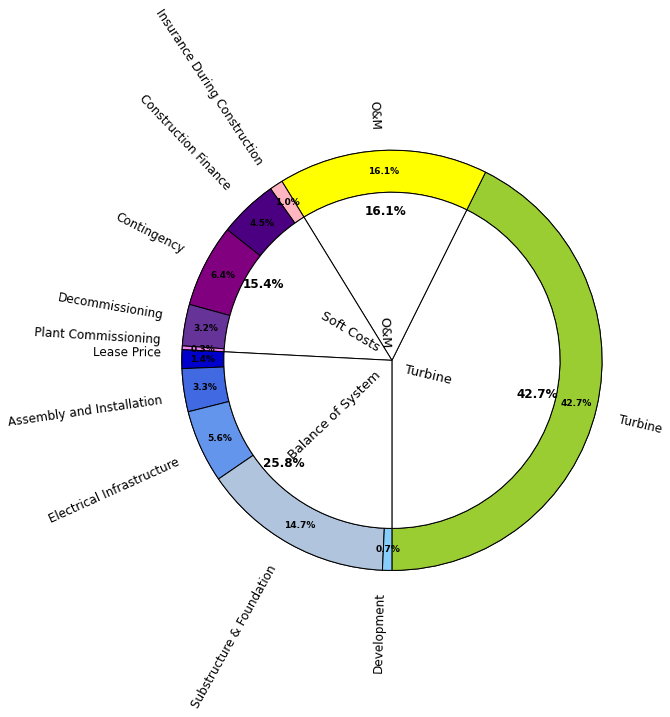

In [7]:
# Plot
start_angle = -90
plt.figure(figsize=(10,10))
names = ['Turbine',
         
         'O&M',
         
         'Insurance During Construction',            # 
         'Construction Finance',   #
         'Contingency',
         'Decommissioning',
         'Plant Commissioning',
         
         'Lease Price',
         'Assembly and Installation',
         'Electrical Infrastructure',
         'Substructure & Foundation',
         'Development']              #

sub_colors = ['yellowgreen',
              
              'yellow', 
              
              'lightpink',
              'indigo',
              'purple', 
              'rebeccapurple', 
              'violet',
              
              'mediumblue',
              'royalblue', 
              'cornflowerblue',
              'lightsteelblue', 
              'lightskyblue']

size = [turbine_capex_kW, 
        
        o_and_m_kW,
        
        insurance_during_construction_kW, 
        construction_finance_kW, 
        contingency_kW,
        decommissioning_kW,
        plant_commissioning_kW,
        
        lease_price_kW,
        assembly_installation_kW, 
        electrical_infrastructure_kW,
        substructure_foundation_kW,
        development_kW]

# Plot

# Internal Pies
sub_names = ['Turbine', 'O&M', 'Soft Costs', 'Balance of System']

a = 'white'
sub_size = [turbine_capex_kW, o_and_m_kW, soft_costs_kW, bos_capex_kW]

plt.pie(size, 
        labels = names, 
        startangle=start_angle,
        colors = sub_colors,
        rotatelabels=True,
        radius= 1.0, 
        labeldistance=1.1,
        textprops ={'fontsize':12, 'color': "black"},
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black" }) 

no_color = 'w'
plt.pie(size, 
#         labels = names, 
        startangle=start_angle,
        autopct = '%1.1f%%', 
        rotatelabels=True,
        pctdistance = 0.9,
#         colors = [no_color],
        colors = sub_colors,
        radius= 1.0, 
#         labeldistance=1.1,
        textprops={'fontweight': 'bold', 
                   'fontsize':9, 
                   'color': "black"},
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black" }) 



# Internal Pies
plt.pie(sub_size,
        autopct = '%1.1f%%', 
        pctdistance = 0.89,
        rotatelabels=True,
        startangle=start_angle, 
        radius= 0.80, 
        textprops ={
            'fontweight': 'bold' ,
            'fontsize':12, 
            'color': "black"}, 
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black" } )

plt.pie(sub_size,
        startangle=start_angle, 
        labeldistance =0.07, 
        labels = sub_names,
        rotatelabels=True,
        radius= 0.80, 
        colors=[a, a, a],
        # Labeling for internal pie chart (Turbine, BOS, Financial)
        textprops ={'fontsize':13, 'color': "black"}, 
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black" } )



# show it
# plt.update_traces()
# plt.legend()
plt.tight_layout()
plt.savefig(path + 'fig_es2.eps', format='eps', dpi=1000)
plt.show()



<br/><br/>
# <center>Figure ES6.  Fixed-bottom offshore wind power plant assumption and ranges for key LCOE input parameters

In [10]:
# Tornado chart template obtained from 
# https://python.plainenglish.io/how-to-create-a-beautify-tornado-chart-in-python-plotly-6c0519e185b4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

lcoe = 77    # $/MWh
y_labels = ['Project Design Life (years)',
         'Discount Rate (nominal) [%]',
         'Net Capacity Factor (%)',
         'OpEx ($/kW/yr)',
         'CapEx ($/kW)']


upper_capex = 110
upper_opex = 90
upper_net_cf = 105
upper_discount_rate = 85
upper_project_design_life = 100
upper_bound = [upper_project_design_life, 
               upper_discount_rate, 
               upper_net_cf,
               upper_opex,
               upper_capex]

# Values to go into bar labels
upper_capex_label = 6059
upper_opex_label = 166
upper_net_cf_label = 35
upper_discount_rate_label = 6.61
upper_project_design_life_label = 15
upper_bound_label = [upper_project_design_life_label, 
                    upper_discount_rate_label, 
                    upper_net_cf_label,
                    upper_opex_label,
                    upper_capex_label]

# ajdust for lcoe 
upper_bound_lcoe_adjustment = [x - lcoe for x in upper_bound]

lower_capex = lcoe - 50
lower_opex = lcoe - 65
lower_net_cf = lcoe - 75
lower_discount_rate = lcoe - 70
lower_project_design_life = lcoe - 73
lower_bound = [lower_project_design_life, 
               lower_discount_rate, 
               lower_net_cf,
               lower_opex,
               lower_capex]

# Values to go into bar labels
lower_capex_label = 2045
lower_opex_label = 55
lower_net_cf_label = 50.0
lower_discount_rate_label = 3.97
lower_project_design_life_label = 35
lower_bound_label = [lower_project_design_life_label, 
                    lower_discount_rate_label, 
                    lower_net_cf_label,
                    lower_opex_label,
                    lower_capex_label]

# Values for reference case
base_capex = 0.001
base_opex = 0.001
base_net_cf = 0.001
base_discount_rate = 0.001
base_project_design_life = 0.001
base_bound = [base_project_design_life, 
               base_discount_rate, 
               base_net_cf,
               base_opex,
               base_capex]

# Values to go into bar labels (reference)
base_capex_label = 3756
base_opex_label = 110
base_net_cf_label = 48.9
base_discount_rate_label = 5.29
base_project_design_life_label = 25
base_bound_label = [base_project_design_life_label, 
                    base_discount_rate_label, 
                    base_net_cf_label,
                    base_opex_label,
                    base_capex_label]

#convert lower_bound to negative values
def Convert(lst):
    return [ -i for i in lst ]

negative_lower_bound = Convert(lower_bound)
# ajdust for lcoe 
negative_lower_bound_lcoe_adjustment = [x + lcoe for x in negative_lower_bound]

fig = go.Figure()



customscale=["rgb(51,153,255)",
            "rgb(102, 166, 30)",
            "rgb(230, 131, 16)", 
            "rgb(153, 153, 153)",
            "rgb(51, 34, 136)"]
z = customscale

fig.add_trace(go.Bar(y=y_labels, x=upper_bound_lcoe_adjustment,
                base=lcoe,
                marker=dict(color = z, colorscale=customscale),
                orientation='h',
                marker_line_width=1.5,
                text = [round(elem, 1) for elem in upper_bound_label],
                textposition='auto',
                textfont=dict(color="white")
                    ))

fig.add_trace(go.Bar(y=y_labels, x=base_bound,
                base= lcoe,
                marker=dict(color = z, colorscale=customscale),
                orientation='h',
                text = [round(elem, 1) for elem in base_bound_label],
                textposition='auto',
                textfont=dict(color="white")
              ))

fig.add_trace(go.Bar(y=y_labels, x=negative_lower_bound,
                base= lcoe,
                marker=dict(color = z, colorscale=customscale),
                orientation='h',
                text = [round(elem, 1) for elem in lower_bound_label],
                textposition='inside',
                textfont=dict(color="white")
              ))

fig.update_layout(height=500,
                  margin=dict(t=50,l=10,b=10,r=10),title_text="Land-based wind power plant assumptions and ranges for key LCOE input parameters",
                  title_font_family="sans-serif",
                  title_font_size = 25,
                  title_font_color="black",
                  title_x=0.5 #to adjust the position along x-axis of the title
                 )

fig.update_layout(
                  barmode='overlay', 
                  xaxis_tickangle=-45, 
                  xaxis=dict(
                      title="Leveleized Cost of Electricity [Reference LCOE = $" + str(lcoe) +  "/MWh]"),
                  yaxis=dict(
                             title='Key Parameters for LCOE Sensitivity Analysis', 
                             titlefont_size=16, 
                             tickfont_size=14),
                  bargap=0.30, 
                  paper_bgcolor='white',
                  plot_bgcolor='white',
                 )
fig.update(layout_showlegend=False)
# fig.savefig(path + 'fig_es6.eps', format='eps', dpi=1000)
fig.write_image(path + 'fig_es6.eps', scale=1, width=1000, height=800)
fig.show()